In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from joblib import load, dump

from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, accuracy_score, f1_score, recall_score
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import shap

# Paths
PROJECT_ROOT = Path().resolve().parent
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
TABLES_DIR  = PROJECT_ROOT / "reports" / "tables"
MODELS_DIR  = PROJECT_ROOT / "models"
ART_DIR     = PROJECT_ROOT / "reports" / "artifacts"

for d in [FIGURES_DIR, TABLES_DIR, MODELS_DIR, ART_DIR]:
    d.mkdir(parents=True, exist_ok=True)

shap.initjs()

In [2]:
def to_numeric_df(X: pd.DataFrame) -> pd.DataFrame:
    """bool->int """
    X = X.copy()
    bool_cols = X.select_dtypes(include="bool").columns
    if len(bool_cols) > 0:
        X[bool_cols] = X[bool_cols].astype(int)
    return X.astype(float)

In [3]:
# --- STATUS
xgb_status = load(ART_DIR / "xgb_status.joblib")
X_test_s = pd.read_csv(ART_DIR / "X_test_status.csv")
y_test_s = pd.read_csv(ART_DIR / "y_test_status.csv")["target"].astype(int)

# --- DURACIÓN
xgb_dur = load(ART_DIR / "xgb_dur.joblib")
X_test_d = pd.read_csv(ART_DIR / "X_test_dur.csv")
y_test_d = pd.read_csv(ART_DIR / "y_test_dur.csv")["DurationPrimaryDays"].astype(float)

print("STATUS:", X_test_s.shape, y_test_s.shape)
print("DURACIÓN:", X_test_d.shape, y_test_d.shape)


STATUS: (28956, 45) (28956,)
DURACIÓN: (40935, 45) (40935,)


AUC: 0.841756839646005

--- threshold 0.50 ---
              precision    recall  f1-score   support

           0      0.864     0.451     0.593      5404
           1      0.887     0.984     0.933     23552

    accuracy                          0.884     28956
   macro avg      0.875     0.717     0.763     28956
weighted avg      0.882     0.884     0.869     28956


--- threshold 0.70 ---
              precision    recall  f1-score   support

           0      0.710     0.553     0.622      5404
           1      0.902     0.948     0.925     23552

    accuracy                          0.874     28956
   macro avg      0.806     0.750     0.773     28956
weighted avg      0.866     0.874     0.868     28956



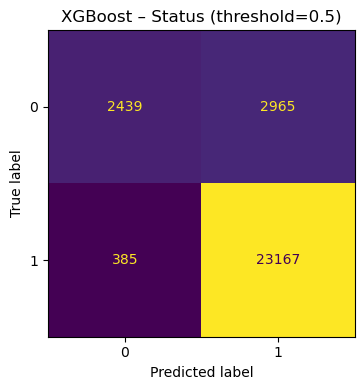

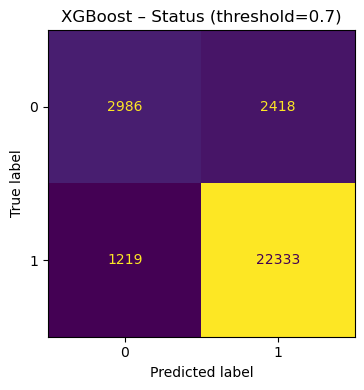

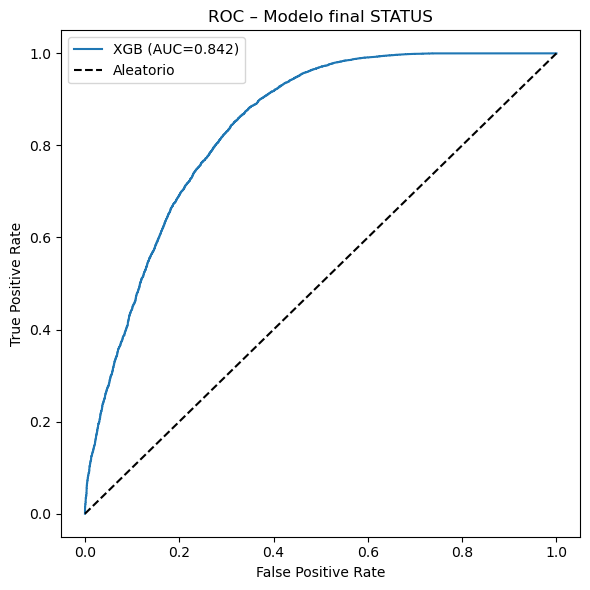

,threshold,accuracy,f1,recall_0,recall_1,auc
0,0.5,0.884307,0.932574,0.451332,0.983653,0.841757
1,0.7,0.874396,0.924704,0.552554,0.948242,0.841757


In [4]:
y_proba_s = xgb_status.predict_proba(X_test_s)[:, 1]

thr_05  = 0.50
thr_alt = 0.70

y_pred_05  = (y_proba_s > thr_05).astype(int)
y_pred_alt = (y_proba_s > thr_alt).astype(int)

auc_val = roc_auc_score(y_test_s, y_proba_s)
print("AUC:", auc_val)

print("\n--- threshold 0.50 ---")
print(classification_report(y_test_s, y_pred_05, digits=3))

print("\n--- threshold 0.70 ---")
print(classification_report(y_test_s, y_pred_alt, digits=3))

# Confusion matrices
for thr, y_pred in [(thr_05, y_pred_05), (thr_alt, y_pred_alt)]:
    cm = confusion_matrix(y_test_s, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"XGBoost – Status (threshold={thr})")
    plt.tight_layout()
    out = FIGURES_DIR / f"status_xgb_confusion_thr_{str(thr).replace('.','_')}.png"
    plt.savefig(out, dpi=300, bbox_inches="tight")
    plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test_s, y_proba_s)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"XGB (AUC={auc_val:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Aleatorio")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – Modelo final STATUS")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / "status_xgb_roc_final.png", dpi=300, bbox_inches="tight")
plt.show()

# Tabla de métricas (AUC es independiente del threshold)
df_metrics_status = pd.DataFrame([
    {
        "threshold": thr_05,
        "accuracy": accuracy_score(y_test_s, y_pred_05),
        "f1": f1_score(y_test_s, y_pred_05),
        "recall_0": recall_score(y_test_s, y_pred_05, pos_label=0),
        "recall_1": recall_score(y_test_s, y_pred_05, pos_label=1),
        "auc": auc_val,
    },
    {
        "threshold": thr_alt,
        "accuracy": accuracy_score(y_test_s, y_pred_alt),
        "f1": f1_score(y_test_s, y_pred_alt),
        "recall_0": recall_score(y_test_s, y_pred_alt, pos_label=0),
        "recall_1": recall_score(y_test_s, y_pred_alt, pos_label=1),
        "auc": auc_val,
    }
])
df_metrics_status.to_csv(TABLES_DIR / "status_xgb_final_metrics.csv", index=False)
df_metrics_status

PermutationExplainer explainer: 401it [00:54,  7.27it/s]                         
C:\Users\Administrador\AppData\Local\Temp\ipykernel_5144\1747996810.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_s, X_shap_s, show=False)


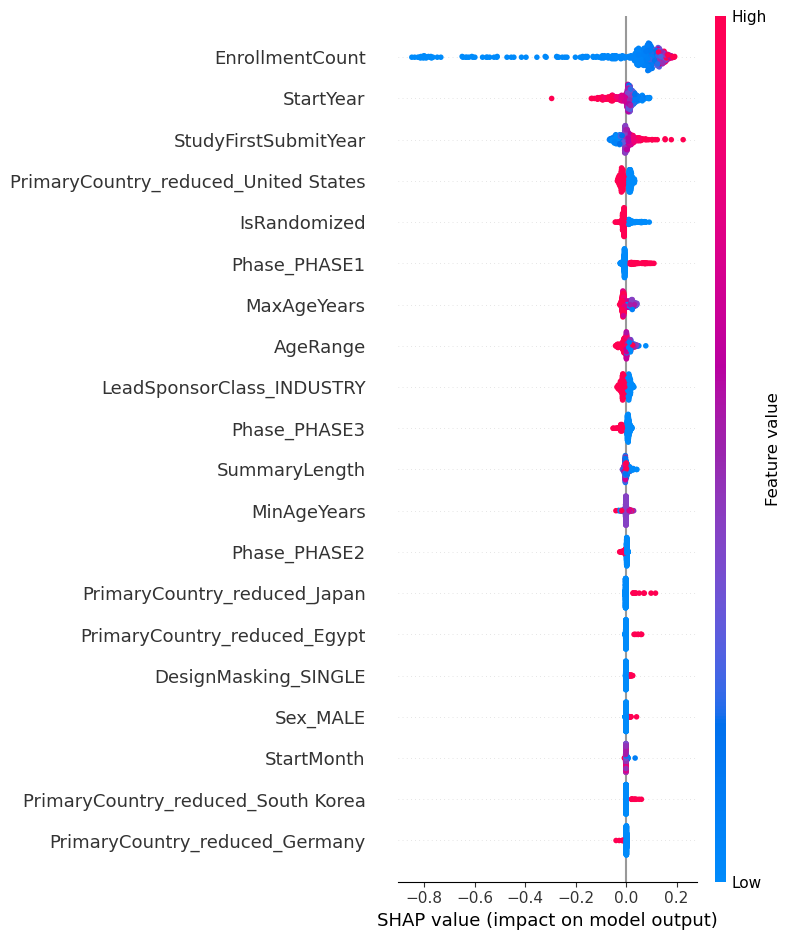

C:\Users\Administrador\AppData\Local\Temp\ipykernel_5144\1747996810.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_s, X_shap_s, plot_type="bar", show=False)


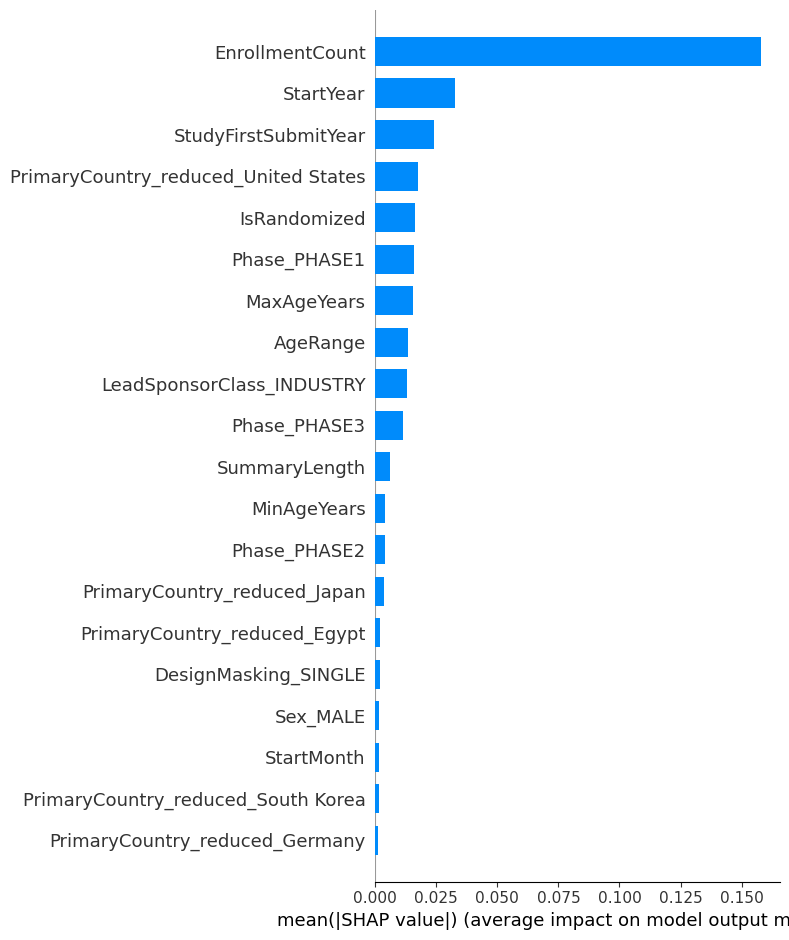

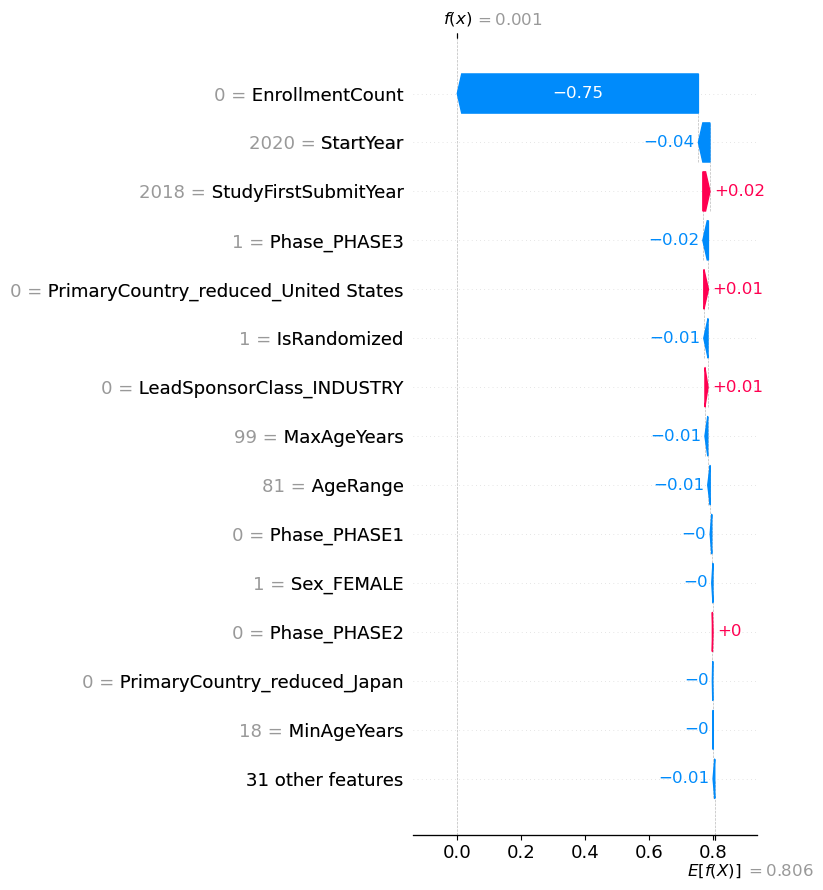

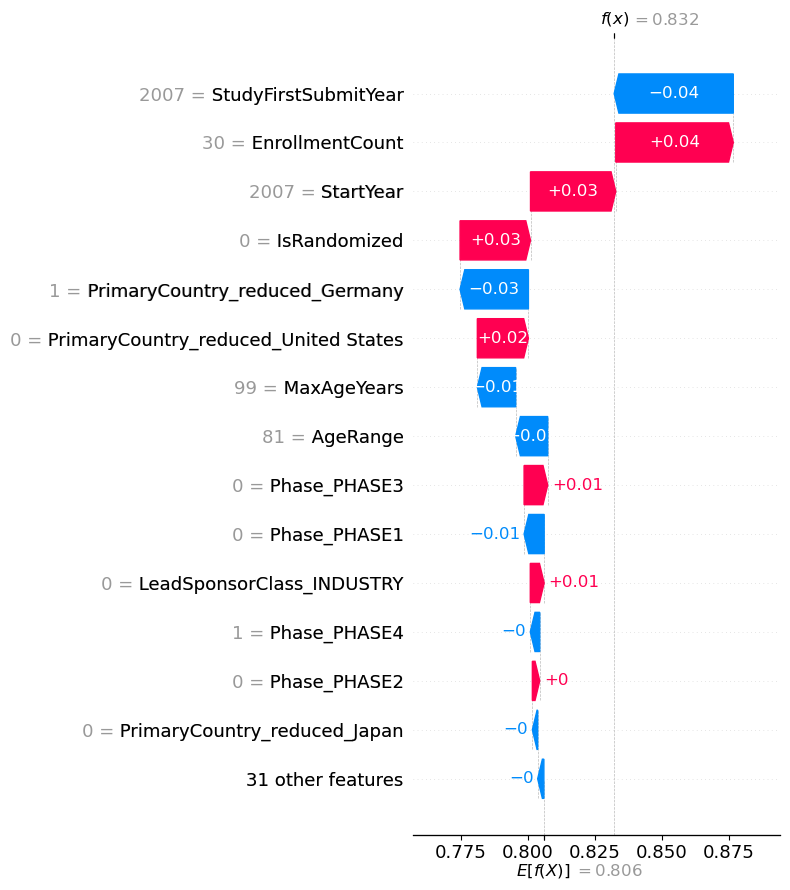

In [5]:
# Submuestra para SHAP (rápido)
sample_size_s = 400
X_shap_s = X_test_s.sample(min(sample_size_s, len(X_test_s)), random_state=42)
X_shap_s = to_numeric_df(X_shap_s)

# Robusto: 
explainer_s = shap.Explainer(xgb_status.predict_proba, X_shap_s)
shap_exp_s = explainer_s(X_shap_s)

# Para clasificación: quedarnos con clase 1
shap_values_s = shap_exp_s.values[:, :, 1]

# Global beeswarm
plt.figure(figsize=(8, 10))
shap.summary_plot(shap_values_s, X_shap_s, show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "status_xgb_shap_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

# Global bar
plt.figure(figsize=(8, 10))
shap.summary_plot(shap_values_s, X_shap_s, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "status_xgb_shap_bar.png", dpi=300, bbox_inches="tight")
plt.show()

# Local: un fallo y un éxito (según threshold 0.5)
idx_fail = X_test_s[(y_pred_05 == 0)].index[0]
idx_succ = X_test_s[(y_pred_05 == 1)].index[0]

x_fail = to_numeric_df(X_test_s.loc[[idx_fail]])
x_succ = to_numeric_df(X_test_s.loc[[idx_succ]])

shap_fail = explainer_s(x_fail)
shap_succ = explainer_s(x_succ)

sv_fail = shap_fail.values[0, :, 1]
sv_succ = shap_succ.values[0, :, 1]

base_fail = shap_fail.base_values[0, 1]
base_succ = shap_succ.base_values[0, 1]

exp_fail = shap.Explanation(
    values=sv_fail,
    base_values=base_fail,
    data=x_fail.iloc[0].values,
    feature_names=x_fail.columns,
)
exp_succ = shap.Explanation(
    values=sv_succ,
    base_values=base_succ,
    data=x_succ.iloc[0].values,
    feature_names=x_succ.columns,
)

# Waterfall FAIL
plt.figure(figsize=(8, 6))
shap.plots.waterfall(exp_fail, max_display=15, show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "status_xgb_shap_waterfall_fail.png", dpi=300, bbox_inches="tight")
plt.show()

# Waterfall SUCCESS
plt.figure(figsize=(8, 6))
shap.plots.waterfall(exp_succ, max_display=15, show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "status_xgb_shap_waterfall_success.png", dpi=300, bbox_inches="tight")
plt.show()



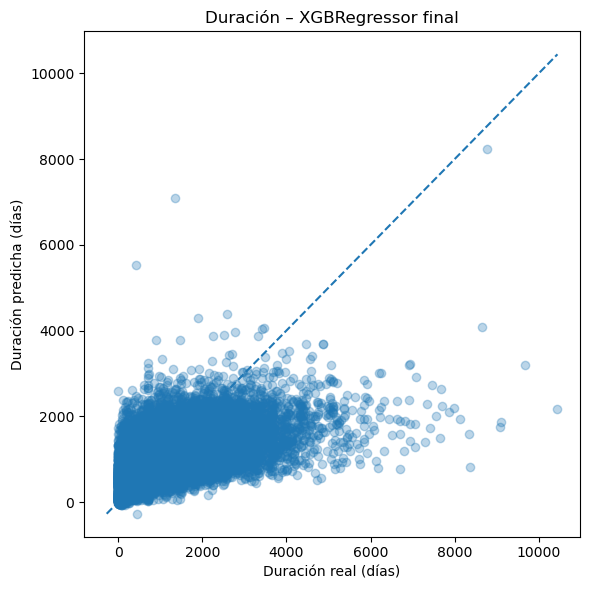

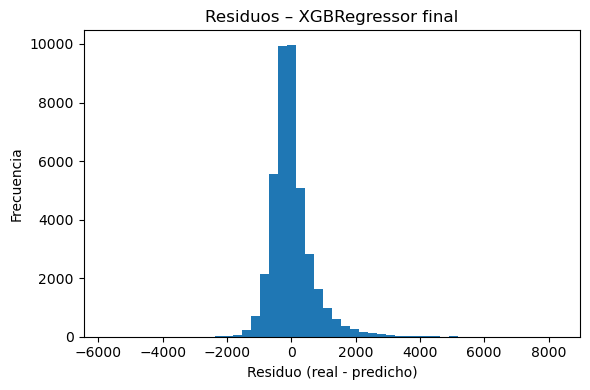

In [6]:
y_pred_d = xgb_dur.predict(X_test_d)

rmse = mean_squared_error(y_test_d, y_pred_d) ** 0.5
mae  = mean_absolute_error(y_test_d, y_pred_d)
r2   = r2_score(y_test_d, y_pred_d)

df_metrics_dur = pd.DataFrame([{
    "model": "XGBRegressor_final",
    "rmse": rmse,
    "mae": mae,
    "r2": r2
}])
df_metrics_dur.to_csv(TABLES_DIR / "duration_xgb_final_metrics.csv", index=False)
df_metrics_dur

# Scatter real vs predicho
plt.figure(figsize=(6, 6))
plt.scatter(y_test_d, y_pred_d, alpha=0.3)
min_val = float(min(y_test_d.min(), y_pred_d.min()))
max_val = float(max(y_test_d.max(), y_pred_d.max()))
plt.plot([min_val, max_val], [min_val, max_val], "--")
plt.xlabel("Duración real (días)")
plt.ylabel("Duración predicha (días)")
plt.title("Duración – XGBRegressor final")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "duration_xgb_scatter_final.png", dpi=300, bbox_inches="tight")
plt.show()

# Residuos
residuals = y_test_d - y_pred_d
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50)
plt.xlabel("Residuo (real - predicho)")
plt.ylabel("Frecuencia")
plt.title("Residuos – XGBRegressor final")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "duration_xgb_residuals_final.png", dpi=300, bbox_inches="tight")
plt.show()



PermutationExplainer explainer: 401it [01:23,  4.71it/s]                         
C:\Users\Administrador\AppData\Local\Temp\ipykernel_5144\2263893318.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_exp_d.values, X_shap_d, show=False)


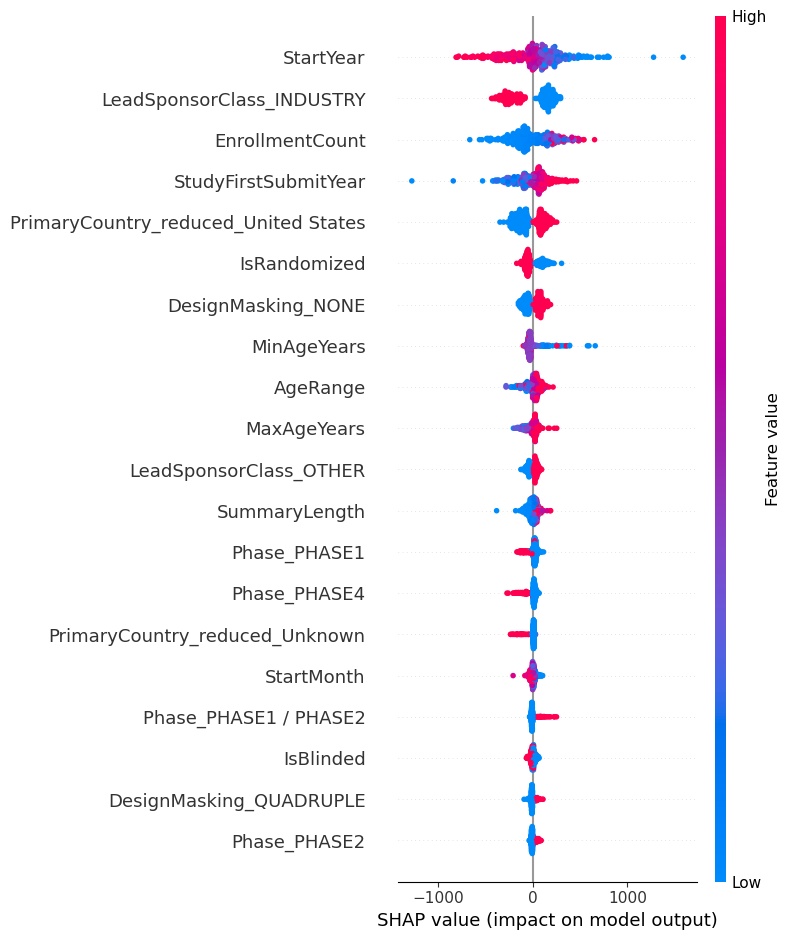

C:\Users\Administrador\AppData\Local\Temp\ipykernel_5144\2263893318.py:27: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_exp_d.values, X_shap_d, plot_type="bar", show=False)


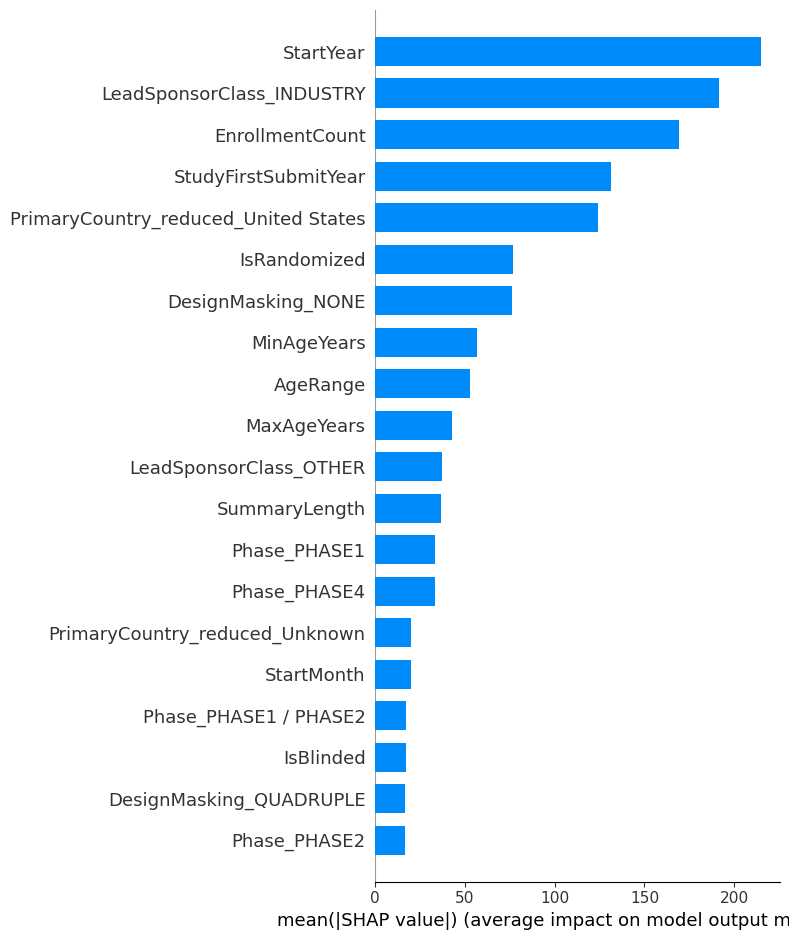

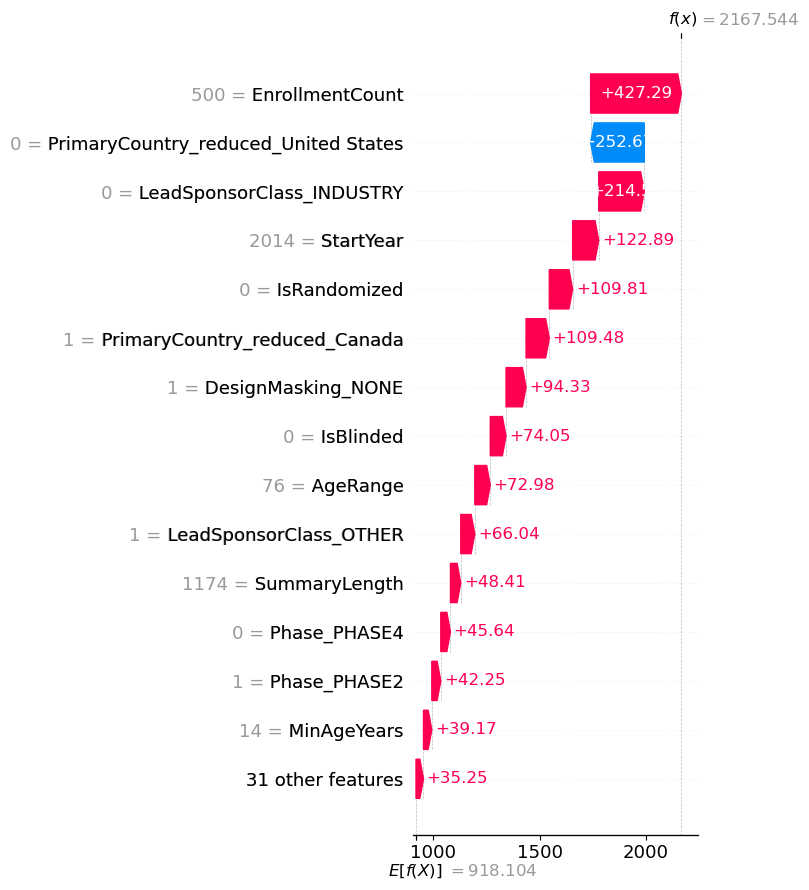

In [8]:
def predict_dur(X):
    # SHAP puede pasar numpy -> lo volvemos df con las mismas columnas
    X_df = pd.DataFrame(X, columns=X_shap_d.columns)
    return xgb_dur.predict(X_df)

sample_size_d = 400
X_shap_d = X_test_d.sample(min(sample_size_d, len(X_test_d)), random_state=42).copy()
X_shap_d = to_numeric_df(X_shap_d)

explainer_d = shap.explainers.Permutation(
    predict_dur,
    X_shap_d,
    max_evals=2 * X_shap_d.shape[1] + 1
)

shap_exp_d = explainer_d(X_shap_d)  # Explanation (n, f)

# Global beeswarm
plt.figure(figsize=(8, 10))
shap.summary_plot(shap_exp_d.values, X_shap_d, show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "duration_xgb_shap_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

# Global bar
plt.figure(figsize=(8, 10))
shap.summary_plot(shap_exp_d.values, X_shap_d, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "duration_xgb_shap_bar.png", dpi=300, bbox_inches="tight")
plt.show()

# Local: el más largo (limpiando y_test_d por si viene tipo "[9.04E2]")
y_test_d_clean = pd.to_numeric(
    y_test_d.astype(str).str.replace(r"[\[\]]", "", regex=True).str.strip(),
    errors="coerce"
)
idx_long = y_test_d_clean.idxmax()

x_long = to_numeric_df(X_test_d.loc[[idx_long]])
shap_exp_long = explainer_d(x_long)

plt.figure(figsize=(8, 6))
shap.plots.waterfall(shap_exp_long[0], max_display=15, show=False)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "duration_xgb_shap_waterfall_long.png", dpi=300, bbox_inches="tight")
plt.show()

In [9]:
dump(xgb_status, MODELS_DIR / "status_xgb_final.joblib")
dump(xgb_dur, MODELS_DIR / "duration_xgb_final.joblib")


['C:\\Users\\Administrador\\Documents\\tfm_clinicaltrials\\models\\duration_xgb_final.joblib']